# **Обработка данных. Отбор признаков методом фильтрации-корреляции. Прогнозирование стоимости жилой недвижимости с применением линейной регрессии.**

In [92]:
import pandas as pd
from sklearn import metrics
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

start = dt.now()


data = pd.read_csv('/content/sample_data/_real_estate_data.csv', index_col=0)
pd.set_option('display.max_columns', 500)
data.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [93]:
data.shape

(23699, 22)

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

# Анализ данных

In [95]:
# Заменяем оставшиеся пустые значения высоты потолков на медианное значение по всему датасету
data['ceiling_height'] = data.groupby(['locality_name', 'floors_total'])['ceiling_height'].apply(lambda x: x.fillna(x.median()))
data['ceiling_height'].fillna(data['ceiling_height'].median(), inplace=True)

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/p

In [96]:
# Удаляем записи, где отсутствует локация и этажность
data.dropna(subset=['locality_name'], inplace=True)
data.dropna(subset=['floors_total'], inplace=True)

In [97]:
# Заменяем пустые значения жилой площади и площади кухни
living_ratio = data['living_area'].mean() / data['total_area'].mean()
kitchen_ratio = data['kitchen_area'].mean() / data['total_area'].mean()
data['living_area'].fillna(living_ratio * data['total_area'], inplace=True)
data['kitchen_area'].fillna(kitchen_ratio * data['total_area'], inplace=True)

In [98]:
# Выясняем количество значений в аппартаментах. Всего аппартаменты - 50. Заменяем пропущенные значения на нет
data['is_apartment'] = data['is_apartment'].fillna(value=False)
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                 11475
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64

In [99]:
# Приводим в целочисленный тип количество балконов. Заменяем пропущенные значения на 0
data['balcony'] = data['balcony'].fillna(value=0).astype(int)

In [100]:
data['price_for_m2']=data['last_price']/data['living_area']# Посчитали и сделали столбец со стоимостью за м2
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_m2
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.000000,8,False,False,False,25.000000,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,254901.960784
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.600000,1,False,False,False,11.000000,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,180107.526882
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.60,5.0,34.300000,4,False,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,151486.880466
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.60,14.0,90.816648,9,False,False,False,27.836861,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,714626.687533
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.000000,13,False,False,False,41.000000,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,312500.000000


In [101]:
data['price_for_m2'].isna().sum()

0

In [102]:
grouped_price = data.groupby('locality_name')['price_for_m2'].transform('mean') # группируем по району(средняя цена у каждой группы)
nan=data.groupby('locality_name')['price_for_m2'].mean()
nan.sort_values()

locality_name
деревня Малая Романовка              14808.362369
деревня Старополье                   18519.042595
деревня Выскатка                     18856.907895
посёлок станции Свирь                18970.699456
деревня Вахнова Кара                 20463.666177
                                        ...      
Кудрово                             206544.556584
Санкт-Петербург                     215028.546340
Зеленогорск                         218860.191692
посёлок Лисий Нос                   220052.604649
садовое товарищество Новая Ропша    250000.000000
Name: price_for_m2, Length: 364, dtype: float64

In [103]:
data['price_for_m2'].fillna(grouped_price,inplace=True)# Заполняем пропуски медианным значением
data.dropna(subset=['price_for_m2'],inplace=True) # удаляем если остались  nan
data['price_for_m2'].isna().sum()

0

In [104]:
grouped_airpots_nearest=data.groupby('locality_name')['airports_nearest'].transform('mean') 
data['airports_nearest'].isnull().sum()

5524

In [105]:
data['airports_nearest'].fillna(grouped_airpots_nearest,inplace=True)#заполняем пропуски расстояния до аэропорта по среднемму значению расстояния в зависимости от района.
data['airports_nearest']=data['airports_nearest'].fillna(data['airports_nearest'].mean()) #где остались пропуски расстояния до аэропорта  заполняем просто по среднемму значению
data['airports_nearest'].isnull().sum()

0

In [106]:
data['is_apartment']=data['is_apartment'].astype('bool') # переводим в бул
data['is_apartment'] = data['is_apartment'].apply(lambda x: 1 if x == "True" else 0) # переводим в 1 и 0
data['studio'] = data['studio'].apply(lambda x: 1 if x == "True" else 0)
data['open_plan'] = data['open_plan'].apply(lambda x: 1 if x == "True" else 0)

In [107]:
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest            0
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
price_for_m2                0
dtype: int64

In [108]:
data['cityCenters_nearest'].fillna(data.groupby('locality_name')['cityCenters_nearest'].transform('mean'),inplace=True)
data['cityCenters_nearest']=data['cityCenters_nearest'].fillna(data['cityCenters_nearest'].mean())#заполняем пропуски расстояния до центра по среднемму значению расстояния
data['cityCenters_nearest'].isnull().sum()

0

In [109]:
data['parks_around3000']=data['parks_around3000'].fillna(data['parks_around3000'].mean())#заполняем средним
data['parks_around3000']=data['parks_around3000'].astype('int64')
data['parks_nearest']=data['parks_nearest'].fillna(data['parks_nearest'].mean())#заполняем средним
data['ponds_around3000']=data['ponds_around3000'].fillna(data['ponds_around3000'].mean())#заполняем средним
data['ponds_around3000']=data['ponds_around3000'].astype('int64')
data['ponds_nearest']=data['ponds_nearest'].fillna(data['ponds_nearest'].mean())#заполняем средним
data.isnull().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest           0
cityCenters_nearest        0
parks_around3000           0
parks_nearest              0
ponds_around3000           0
ponds_nearest              0
days_exposition         3171
price_for_m2               0
dtype: int64

In [110]:
data['days_exposition']=data['days_exposition'].fillna(data['days_exposition'].median())
data['days_exposition']=data['days_exposition'].astype('int64')

In [111]:
data.isnull().sum()

total_images            0
last_price              0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
is_apartment            0
studio                  0
open_plan               0
kitchen_area            0
balcony                 0
locality_name           0
airports_nearest        0
cityCenters_nearest     0
parks_around3000        0
parks_nearest           0
ponds_around3000        0
ponds_nearest           0
days_exposition         0
price_for_m2            0
dtype: int64

In [112]:
data['first_day_exposition']=pd.to_datetime(data['first_day_exposition'],format='%Y.%m.%dT%H:%M:%S')#перевожу в формат даты
data['first_day_exposition']=data['first_day_exposition'].dt.round('1D') # округляю до дня
data.head()
# Добавляем столбцы дня недели, месяца и года
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

In [113]:
data = data.drop('first_day_exposition', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [114]:
data.head()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_m2,weekday,month,year
0,20,13000000.0,108.0,3,2.70,16.0,51.000000,8,0,0,0,25.000000,0,Санкт-Петербург,18863.0,16028.0,1,482.000000,2,755.000000,95,254901.960784,3,3,2019
1,7,3350000.0,40.4,1,2.65,11.0,18.600000,1,0,0,0,11.000000,2,посёлок Шушары,12817.0,18603.0,0,490.580448,0,518.289509,81,180107.526882,1,12,2018
2,10,5196000.0,56.0,2,2.60,5.0,34.300000,4,0,0,0,8.300000,0,Санкт-Петербург,21741.0,13933.0,1,90.000000,2,574.000000,558,151486.880466,3,8,2015
3,0,64900000.0,159.0,3,2.60,14.0,90.816648,9,0,0,0,27.836861,0,Санкт-Петербург,28098.0,6800.0,2,84.000000,3,234.000000,424,714626.687533,4,7,2015
4,2,10000000.0,100.0,2,3.03,14.0,32.000000,13,0,0,0,41.000000,0,Санкт-Петербург,31856.0,8098.0,2,112.000000,1,48.000000,121,312500.000000,1,6,2018


In [115]:
#Вычисляем столбцы с категорийными признаками, затем заменяем их на числа
from sklearn.preprocessing import LabelEncoder
categorical_columns = data.columns[data.dtypes == 'object']
labelencoder = LabelEncoder()
for column in categorical_columns:
    data[column] = labelencoder.fit_transform(data[column])
    print(dict(enumerate(labelencoder.classes_)))

{0: 'Бокситогорск', 1: 'Волосово', 2: 'Волхов', 3: 'Всеволожск', 4: 'Выборг', 5: 'Высоцк', 6: 'Гатчина', 7: 'Зеленогорск', 8: 'Ивангород', 9: 'Каменногорск', 10: 'Кингисепп', 11: 'Кириши', 12: 'Кировск', 13: 'Колпино', 14: 'Коммунар', 15: 'Красное Село', 16: 'Кронштадт', 17: 'Кудрово', 18: 'Лодейное Поле', 19: 'Ломоносов', 20: 'Луга', 21: 'Любань', 22: 'Мурино', 23: 'Никольское', 24: 'Новая Ладога', 25: 'Отрадное', 26: 'Павловск', 27: 'Петергоф', 28: 'Пикалёво', 29: 'Подпорожье', 30: 'Приморск', 31: 'Приозерск', 32: 'Пушкин', 33: 'Санкт-Петербург', 34: 'Светогорск', 35: 'Сертолово', 36: 'Сестрорецк', 37: 'Сланцы', 38: 'Сосновый Бор', 39: 'Сясьстрой', 40: 'Тихвин', 41: 'Тосно', 42: 'Шлиссельбург', 43: 'городской поселок Большая Ижора', 44: 'городской поселок Янино-1', 45: 'городской посёлок Будогощь', 46: 'городской посёлок Виллози', 47: 'городской посёлок Лесогорский', 48: 'городской посёлок Мга', 49: 'городской посёлок Назия', 50: 'городской посёлок Новоселье', 51: 'городской посёлок 

In [116]:
data.head()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_m2,weekday,month,year
0,20,13000000.0,108.0,3,2.70,16.0,51.000000,8,0,0,0,25.000000,0,33,18863.0,16028.0,1,482.000000,2,755.000000,95,254901.960784,3,3,2019
1,7,3350000.0,40.4,1,2.65,11.0,18.600000,1,0,0,0,11.000000,2,326,12817.0,18603.0,0,490.580448,0,518.289509,81,180107.526882,1,12,2018
2,10,5196000.0,56.0,2,2.60,5.0,34.300000,4,0,0,0,8.300000,0,33,21741.0,13933.0,1,90.000000,2,574.000000,558,151486.880466,3,8,2015
3,0,64900000.0,159.0,3,2.60,14.0,90.816648,9,0,0,0,27.836861,0,33,28098.0,6800.0,2,84.000000,3,234.000000,424,714626.687533,4,7,2015
4,2,10000000.0,100.0,2,3.03,14.0,32.000000,13,0,0,0,41.000000,0,33,31856.0,8098.0,2,112.000000,1,48.000000,121,312500.000000,1,6,2018


In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   total_images         23565 non-null  int64  
 1   last_price           23565 non-null  float64
 2   total_area           23565 non-null  float64
 3   rooms                23565 non-null  int64  
 4   ceiling_height       23565 non-null  float64
 5   floors_total         23565 non-null  float64
 6   living_area          23565 non-null  float64
 7   floor                23565 non-null  int64  
 8   is_apartment         23565 non-null  int64  
 9   studio               23565 non-null  int64  
 10  open_plan            23565 non-null  int64  
 11  kitchen_area         23565 non-null  float64
 12  balcony              23565 non-null  int64  
 13  locality_name        23565 non-null  int64  
 14  airports_nearest     23565 non-null  float64
 15  cityCenters_nearest  23565 non-null 

In [118]:
data['last_price'].describe()

count    2.356500e+04
mean     6.540058e+06
std      1.091093e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.646000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64

In [119]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_m2,weekday,month,year
count,23565.000000,2.356500e+04,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.0,23565.0,23565.0,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,2.356500e+04,23565.000000,23565.000000,23565.000000
mean,9.878421,6.540058e+06,60.322824,2.070656,2.737873,10.675875,34.592277,5.878124,0.0,0.0,0.0,10.499898,0.593677,60.486909,28794.303783,14193.186076,0.468831,490.580448,0.589900,518.289509,169.203692,1.862317e+05,2.567367,6.401570,2017.371016
std,5.681156,1.091093e+07,35.657060,1.078591,1.009172,6.594823,22.373679,4.871485,0.0,0.0,0.0,6.037750,0.960660,81.593682,11057.730152,7553.339746,0.748403,199.383722,0.883966,172.146937,206.497729,1.812266e+05,1.788279,3.492948,1.037393
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,0.0,0.0,0.0,1.300000,0.000000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000,3.809375e+02,0.000000,1.000000,2014.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.550000,5.000000,19.000000,2.000000,0.0,0.0,0.0,7.000000,0.000000,33.000000,21156.000000,10935.000000,0.000000,490.580448,0.000000,518.289509,45.000000,1.267606e+05,1.000000,3.000000,2017.000000
50%,9.000000,4.646000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,0.0,0.0,0.0,9.000000,0.000000,33.000000,28794.303783,14193.186076,0.000000,490.580448,0.000000,518.289509,95.000000,1.676136e+05,3.000000,6.000000,2017.000000
75%,14.000000,6.790000e+06,69.700000,3.000000,2.750000,16.000000,42.100000,8.000000,0.0,0.0,0.0,12.000000,1.000000,33.000000,34324.000000,15247.000000,1.000000,490.580448,1.000000,518.289509,198.000000,2.200000e+05,4.000000,10.000000,2018.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,0.0,0.0,0.0,112.000000,5.000000,363.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,2.166333e+07,6.000000,12.000000,2019.000000


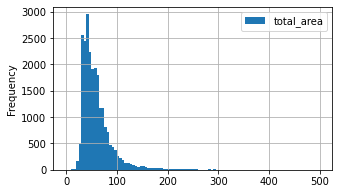

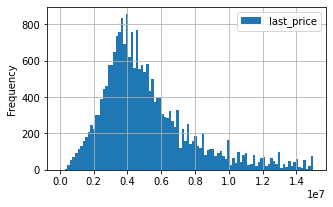

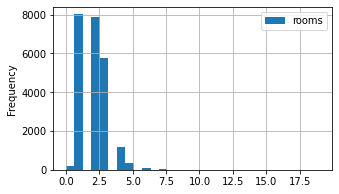

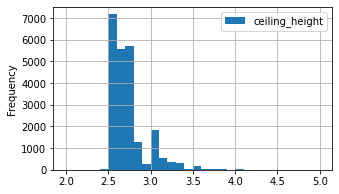

In [120]:
data.plot(y = 'total_area', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (0,500))
data.plot(y = 'last_price', kind = 'hist', bins = 100, grid=True, range = (0,15000000), figsize = (5,3))
data.plot(y = 'rooms', kind = 'hist', bins = 30, grid=True, figsize = (5,3))
data.plot(y = 'ceiling_height', kind = 'hist', bins = 30, range = (2,5), grid=True, figsize = (5,3))

Большее число квартир имеет: 


*   общую площадь от 20 до 100 м2;
*   цены на квартиры от 2 до 6 млн руб;
*   комнат от 1-3;
*   высоту потолков равную 2,7м.







**Обнаружение и отброс выбросов**

In [121]:
# Функция для подсчёта границ с учетом 1.5 размаха
def quartile_range(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    dfq = data.loc[(data[column] < q3 + 1.5*iqr) & (data[column] > q1 - 1.5*iqr), column]
    return dfq
# Столбцы с выбросами
list_features = ['last_price', 'total_area', 'kitchen_area', 'living_area', 'days_exposition', 'ceiling_height', 'rooms']
for col in list_features:
    data[col] = quartile_range(data, col)

# Возвращаем в целочисленный тип число комнат
data['rooms'] = data['rooms'].fillna(0).astype(int)

# Изучаем, есть ли выбивающиеся значения
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_m2,weekday,month,year
count,23565.000000,2.151900e+04,22326.000000,23565.000000,21837.000000,23565.000000,22682.000000,23565.000000,23565.0,23565.0,23565.0,22250.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,21228.000000,2.356500e+04,23565.000000,23565.000000,23565.000000
mean,9.878421,4.837115e+06,54.319704,2.013495,2.659333,10.675875,31.526984,5.878124,0.0,0.0,0.0,9.417840,0.593677,60.486909,28794.303783,14193.186076,0.468831,490.580448,0.589900,518.289509,112.794564,1.862317e+05,2.567367,6.401570,2017.371016
std,5.681156,2.215774e+06,19.331030,0.986750,0.143003,6.594823,13.752739,4.871485,0.0,0.0,0.0,3.177523,0.960660,81.593682,11057.730152,7553.339746,0.748403,199.383722,0.883966,172.146937,96.371987,1.812266e+05,1.788279,3.492948,1.037393
min,0.000000,1.219000e+04,12.000000,0.000000,2.250000,1.000000,2.000000,1.000000,0.0,0.0,0.0,1.300000,0.000000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000,3.809375e+02,0.000000,1.000000,2014.000000
25%,6.000000,3.300000e+06,39.400000,1.000000,2.550000,5.000000,18.700000,2.000000,0.0,0.0,0.0,7.000000,0.000000,33.000000,21156.000000,10935.000000,0.000000,490.580448,0.000000,518.289509,45.000000,1.267606e+05,1.000000,3.000000,2017.000000
50%,9.000000,4.400000e+06,50.000000,2.000000,2.640000,9.000000,30.000000,4.000000,0.0,0.0,0.0,9.000000,0.000000,33.000000,28794.303783,14193.186076,0.000000,490.580448,0.000000,518.289509,95.000000,1.676136e+05,3.000000,6.000000,2017.000000
75%,14.000000,6.000000e+06,65.500000,3.000000,2.750000,16.000000,40.600000,8.000000,0.0,0.0,0.0,11.000000,1.000000,33.000000,34324.000000,15247.000000,1.000000,490.580448,1.000000,518.289509,146.000000,2.200000e+05,4.000000,10.000000,2018.000000
max,50.000000,1.186686e+07,114.200000,5.000000,3.050000,60.000000,76.700000,33.000000,0.0,0.0,0.0,19.450000,5.000000,363.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,427.000000,2.166333e+07,6.000000,12.000000,2019.000000


In [122]:
data.shape

(23565, 25)

In [123]:
data = data.dropna() 
data.shape

(18131, 25)

In [124]:

# Изучаем, есть ли выбивающиеся значения
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_m2,weekday,month,year
count,18131.000000,1.813100e+04,18131.000000,18131.000000,18131.000000,18131.000000,18131.000000,18131.000000,18131.0,18131.0,18131.0,18131.000000,18131.000000,18131.000000,18131.000000,18131.000000,18131.000000,18131.000000,18131.000000,18131.000000,18131.000000,1.813100e+04,18131.000000,18131.000000,18131.000000
mean,9.756384,4.618170e+06,51.182872,1.873035,2.645168,11.026198,29.384518,6.003033,0.0,0.0,0.0,9.026942,0.614583,65.020352,29082.617041,15196.572257,0.376482,491.291606,0.481827,527.043950,109.907672,1.689960e+05,2.586289,6.396172,2017.546964
std,5.526005,2.050948e+06,16.665646,0.871746,0.133239,6.642334,11.879685,4.933171,0.0,0.0,0.0,2.905262,0.947802,87.275962,11387.628866,7105.558441,0.666516,174.063617,0.779946,161.030846,95.578845,7.522660e+04,1.800866,3.500148,0.891053
min,0.000000,4.300000e+05,12.000000,0.000000,2.250000,1.000000,2.000000,1.000000,0.0,0.0,0.0,1.300000,0.000000,0.000000,0.000000,399.000000,0.000000,1.000000,0.000000,16.000000,1.000000,1.375000e+04,0.000000,1.000000,2014.000000
25%,6.000000,3.250000e+06,38.100000,1.000000,2.550000,5.000000,18.100000,2.000000,0.0,0.0,0.0,6.800000,0.000000,33.000000,20558.000000,12175.500000,0.000000,490.580448,0.000000,518.289509,44.000000,1.231190e+05,1.000000,3.000000,2017.000000
50%,9.000000,4.260000e+06,47.200000,2.000000,2.600000,9.000000,28.500000,5.000000,0.0,0.0,0.0,8.600000,0.000000,33.000000,28794.303783,14193.186076,0.000000,490.580448,0.000000,518.289509,93.000000,1.611111e+05,3.000000,6.000000,2018.000000
75%,14.000000,5.650000e+06,61.300000,2.000000,2.700000,16.000000,37.500000,8.000000,0.0,0.0,0.0,10.800000,1.000000,33.000000,35161.000000,15697.000000,1.000000,490.580448,1.000000,518.289509,143.000000,2.071006e+05,4.000000,10.000000,2018.000000
max,39.000000,1.186686e+07,114.200000,5.000000,3.050000,60.000000,76.200000,33.000000,0.0,0.0,0.0,19.420000,5.000000,363.000000,84853.000000,65952.000000,3.000000,3190.000000,3.000000,1344.000000,427.000000,3.175000e+06,6.000000,12.000000,2019.000000


**Попарная корреляция**

In [125]:
corr_matrix = data.corr().round(2)
corr_matrix

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_m2,weekday,month,year
total_images,1.00,0.18,0.11,0.09,0.02,0.02,0.10,0.03,NaN,NaN,NaN,0.07,0.04,-0.04,-0.00,-0.03,0.02,-0.01,0.00,-0.01,0.01,0.09,-0.01,0.01,0.13
last_price,0.18,1.00,0.67,0.42,0.33,0.27,0.55,0.18,NaN,NaN,NaN,0.49,0.10,-0.22,-0.00,-0.20,0.21,0.04,0.25,0.00,0.02,0.44,-0.01,0.00,0.04
total_area,0.11,0.67,1.00,0.81,0.17,0.00,0.92,-0.01,NaN,NaN,NaN,0.47,0.09,-0.05,0.00,-0.05,0.04,0.02,0.08,0.00,0.07,-0.18,-0.01,0.01,-0.03
rooms,0.09,0.42,0.81,1.00,-0.06,-0.23,0.89,-0.17,NaN,NaN,NaN,0.08,0.02,-0.08,-0.02,-0.03,0.04,-0.01,0.02,0.00,0.06,-0.40,0.00,-0.01,-0.01
ceiling_height,0.02,0.33,0.17,-0.06,1.00,0.24,0.06,0.15,NaN,NaN,NaN,0.33,0.02,-0.01,-0.04,-0.18,0.08,-0.00,0.13,-0.04,0.02,0.28,0.01,0.01,-0.04
floors_total,0.02,0.27,0.00,-0.23,0.24,1.00,-0.15,0.67,NaN,NaN,NaN,0.38,0.16,0.11,0.08,-0.05,-0.11,0.05,0.00,0.02,-0.03,0.43,0.01,0.02,-0.01
living_area,0.10,0.55,0.92,0.89,0.06,-0.15,1.00,-0.12,NaN,NaN,NaN,0.20,0.05,-0.08,-0.02,-0.05,0.06,-0.00,0.06,0.01,0.06,-0.39,0.00,-0.00,-0.02
floor,0.03,0.18,-0.01,-0.17,0.15,0.67,-0.12,1.00,NaN,NaN,NaN,0.26,0.16,0.09,0.05,-0.03,-0.08,0.03,-0.00,0.02,-0.03,0.31,0.01,0.03,-0.01
is_apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
studio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Значимые признаки: Общая площадь, кол-во комнат, жилая площадь, цена за м2, площадь кухни, высота потолков.**

**Так как стандартное отклоение столбцов с бинарными значениями равно нулю, коэффициент корреляции для них не определен**

In [126]:
data.head(10)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_m2,weekday,month,year
1,7,3350000.0,40.40,1,2.650,11.0,18.60000,1,0,0,0,11.00,2,326,12817.000000,18603.000000,0,490.580448,0,518.289509,81.0,180107.526882,1,12,2018
5,10,2890000.0,30.40,1,2.625,12.0,14.40000,5,0,0,0,9.10,0,56,28794.303783,14193.186076,0,490.580448,0,518.289509,55.0,200694.444444,0,9,2018
6,6,3700000.0,37.30,1,2.600,26.0,10.60000,6,0,0,0,14.40,1,296,52996.000000,19143.000000,0,490.580448,0,518.289509,155.0,349056.603774,3,11,2017
7,5,7915000.0,71.60,2,2.750,24.0,40.89605,22,0,0,0,18.90,2,33,23982.000000,11634.000000,0,490.580448,0,518.289509,95.0,193539.473462,3,4,2019
8,20,2900000.0,33.16,1,2.650,27.0,15.43000,26,0,0,0,8.81,0,291,28794.303783,14193.186076,0,490.580448,0,518.289509,189.0,187945.560596,2,5,2018
9,18,5400000.0,61.00,3,2.500,9.0,43.60000,7,0,0,0,6.50,2,33,50898.000000,15008.000000,0,490.580448,0,518.289509,289.0,123853.211009,6,2,2017
10,5,5050000.0,39.60,1,2.670,12.0,20.30000,3,0,0,0,8.50,0,33,38357.000000,13878.000000,1,310.000000,2,553.000000,137.0,248768.472906,3,11,2017
11,9,3300000.0,44.00,2,2.500,5.0,31.00000,4,0,0,0,6.00,1,19,48252.000000,51677.000000,0,490.580448,0,518.289509,7.0,106451.612903,0,8,2018
12,10,3890000.0,54.00,2,2.550,5.0,30.00000,5,0,0,0,9.00,0,35,28794.303783,14193.186076,0,490.580448,0,518.289509,90.0,129666.666667,3,6,2016
13,20,3550000.0,42.80,2,2.560,5.0,27.00000,5,0,0,0,5.20,1,27,37868.000000,33058.000000,1,294.000000,3,298.000000,366.0,131481.481481,5,7,2017


Значимые признаки основываясь на корреляции к целевому показателю добавляются в переменную Х, У - целевой показатель стоимости квартир

In [127]:
X = data[['total_area', 'rooms', 'living_area', 'price_for_m2', 'kitchen_area', 'ceiling_height']]
y = data['last_price']

In [128]:
# импортируем необходимый модуль
from sklearn.model_selection import train_test_split
 
# размер тестовой выборки составит 20%
# также зададим точку отсчета для воспроизводимости
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 10)

In [129]:
#Вычисляет среднюю абсолютную процентную ошибку
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Вычисляет медианную абсолютную процентную ошибку
def median_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100 

#Печатает рассчитанные значения коэффициента детерминации, средней, медианной абсолютных ошибок и корень из средней квадратичной ошибки:
def print_metrics(prediction, val_y):
    val_mae = metrics.mean_absolute_error(val_y, prediction)
    median_AE = metrics.median_absolute_error(val_y, prediction)
    r2 = metrics.r2_score(val_y, prediction)
    rmse = np.sqrt(metrics.mean_squared_error(val_y, prediction))

    print('')
    print('R\u00b2: {:.2}'.format(r2))
    print('')
    print('Средняя абсолютная процентная ошибка: {:.3} %'.format(mean_absolute_percentage_error(val_y, prediction)))
    print('Медианная абсолютная процентная ошибка: {:.3} %'.format(median_absolute_percentage_error(val_y, prediction)))
    print('')
    print('Средняя абсолютная ошибка: ', val_mae)
    print('Медианная абсолютная ошибка: ', median_AE)
    print('Корень из средней квадратичной ошибки: ', rmse)

In [130]:

# размерность обучающей
print(X_train.shape, y_train.shape)
 
# и тестовой выборки
print(X_test.shape, y_test.shape)

(14504, 6) (14504,)
(3627, 6) (3627,)


In [131]:
# из набора линейных моделей библиотеки sklearn импортируем линейную регрессию
from sklearn.linear_model import LinearRegression
 
# создадим объект этого класса и запишем в переменную model
model = LinearRegression()
 
# обучим нашу модель
model.fit(X_train, y_train)

LinearRegression()

In [132]:
# на основе нескольких независимых переменных (Х) предскажем цену на жилье (y)
y_pred = model.predict(X_test)

In [133]:
#Вычисляем и печатаем величины ошибок при сравнении известных цен квартир из валидационной выборки с предсказанными моделью
print_metrics(y_pred, y_test)


R²: 0.87

Средняя абсолютная процентная ошибка: 13.4 %
Медианная абсолютная процентная ошибка: 7.87 %

Средняя абсолютная ошибка:  508388.32978805254
Медианная абсолютная ошибка:  324545.7992718164
Корень из средней квадратичной ошибки:  743588.6643696802


**В данном случае мы видим, что 87% изменчивости цены объясняется независимыми переменными, которые мы выбрали для нашей модели**

In [134]:
# сравним тестовые и прогнозные значения цен на жилье
dat = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
dat


,Actual,Predicted
3822,6000000.0,6.373266e+06
293,900000.0,1.957220e+06
12243,4350000.0,5.532321e+06
18704,3190000.0,3.147807e+06
16323,5400000.0,6.447713e+06
...,...,...
18265,3850000.0,4.198757e+06
12757,3240000.0,3.624204e+06
22669,6800000.0,7.815627e+06
23636,4100000.0,4.742928e+06


In [135]:
running_secs = (dt.now() - start).seconds
print('Время работы алгоритма ',running_secs, 'сек')

Время работы алгоритма  9 сек


***Хотя наша модель не очень точна, прогнозируемые оценки близки к фактическим.***